In [11]:
import swat  
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import dlpy
from dlpy import Model, Sequential
from dlpy.model import *
from dlpy.layers import *
from dlpy.applications import *
from dlpy.utils import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split
from dlpy.model import Optimizer
from dlpy.lr_scheduler import *
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

In [12]:
s=swat.CAS(hostname='http://10.100.252.90/cas-shared-default-http/',port=8777 ,username='pocuser4',password='sasviya')

In [13]:
s.loadactionset('image')
s.loadactionset('deepLearn')
s.loadactionset('astore')

NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000826s, sys: 0.000812s, mem: 0.196mb

In [14]:
#dir_path = 'http://localhost:8888/tree/Computer_vision_POC/Training'
dir_path = '/home/pocuser4/ComputerVision/'
# load images into CAS Tables
trainImgTbl = ImageTable.load_files(s, path=dir_path + 'Training', casout=dict(name='train'))

print("Number of images for training:", trainImgTbl.numrows()["numrows"])

Number of images for training: 19


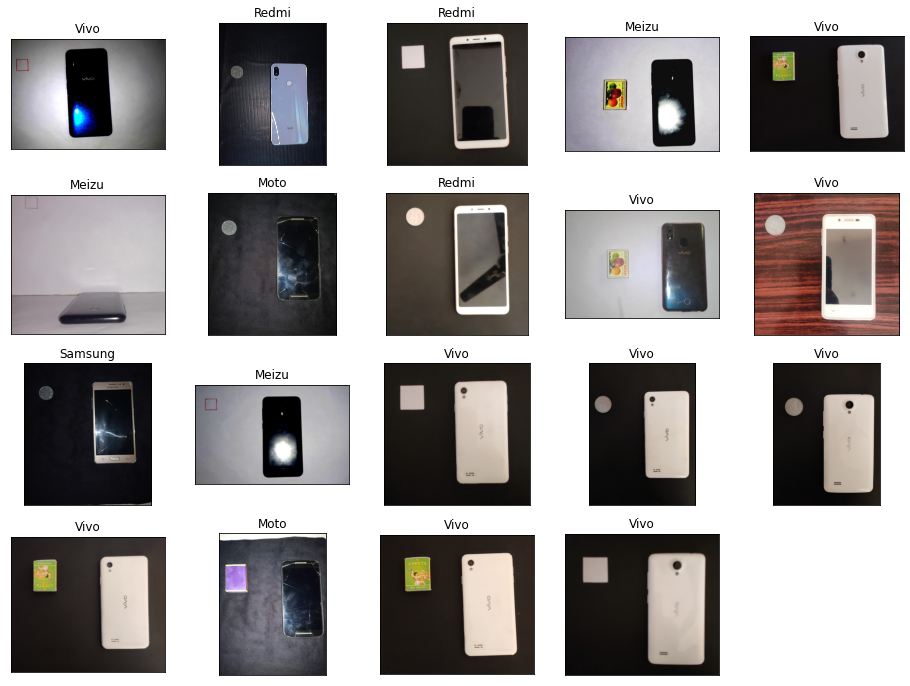

In [15]:
trainImgTbl.show(19,ncol=5,randomize=True)

In [16]:
trainImgTbl.image_summary

jpg                    19
minWidth              960
maxWidth             3000
minHeight             813
maxHeight            4000
meanWidth         1275.26
meanHeight        1266.37
mean1stChannel    88.1954
min1stChannel           0
max1stChannel         255
mean2ndChannel    88.9996
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    94.4554
min3rdChannel           0
max3rdChannel         255
dtype: object

In [17]:
freq= trainImgTbl.label_freq
print("The minimum number of images among each class: ", np.min(freq["Frequency"]))
print("The maximum number of images among each class: ", np.max(freq["Frequency"]))
print(freq)

The minimum number of images among each class:  1
The maximum number of images among each class:  10
Frequency for TRAIN

         Level  Frequency
Meizu        1          3
Moto         2          2
Redmi        3          3
Samsung      4          1
Vivo         5         10


In [18]:
trainImgTbl.head()

,_image_,_label_,_filename_0,_id_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Samsung,Samsung_GalaxyOn5_coin.jpeg,1
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Redmi,Redmi_Note6_box.jpeg,2
2,b'\xff\xd8\xff\xe1\xa4\xb3Exif\x00\x00II*\x00\...,Redmi,Redmi_note7.jpg,3
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Redmi,Redmi_Note_6_coin.jpeg,4
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,Moto,Moto_G3_coin.jpeg,5


In [19]:
trainImgTbl.columnInfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,_image_,1,varbinary,2656622,2656622,0,0
1,_label_,2,varchar,7,7,0,0
2,_filename_0,3,varchar,27,27,0,0
3,_id_,4,int64,8,12,0,0


### Resizing Images Using the processImages Action
#### Input: train datasset    Output:imgsOut dataset

In [21]:
s.image.processImages(
    casout={'name':'imgsOut'},
    imagefunctions=[
        {'options':{
            'functiontype':'RESIZE',
            'width':620,
            'height':800
        }}
    ],
    table={'name':'train'}
)

NOTE: Table TRAIN contains compressed images.
NOTE: 19 out of 19 images were processed successfully and saved as compressed images to the Cloud Analytic Services table imgsOut.


+ Elapsed: 0.225s, user: 1.03s, sys: 0.191s, mem: 69mb

In [22]:
temp=ImageTable.from_table(s.CASTable('imgsOut'), image_col='_image_', label_col='_label_', path_col=None, columns=None, casout=None)

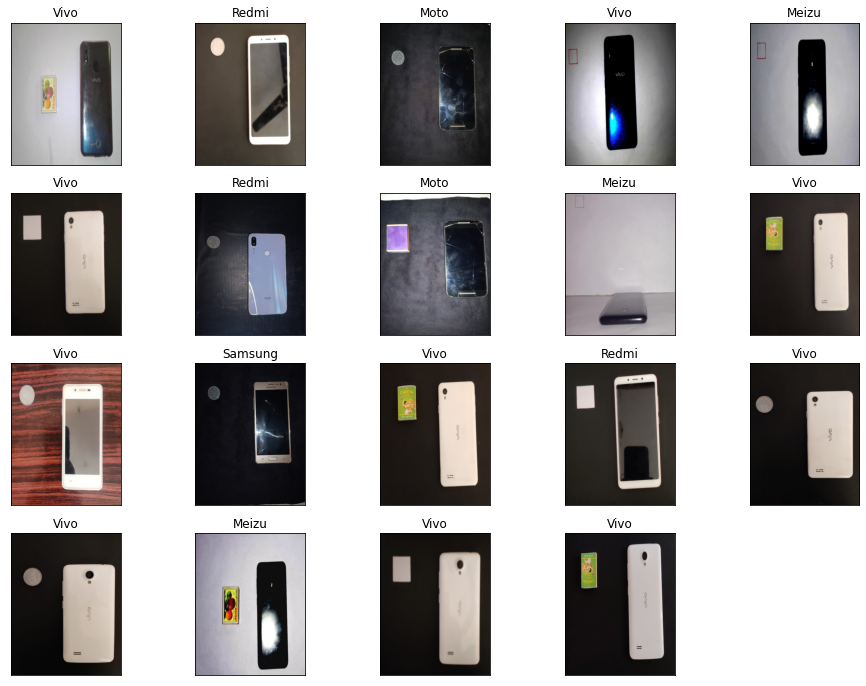

In [23]:
temp.show(19,ncol=5,randomize=True)

### Blurring Images Using the processImages Action
#### Input: imgsOut dataset Output: imgsOut_1 dataset

In [24]:
s.image.processImages(
    casout={'name':'imgsOut_1'},
    imagefunctions=[
        {'options':{
            'functiontype':'GAUSSIAN_FILTER',
            'kernelwidth':21,
            'kernelheight':21
        }}
    ],
    table={'name':'imgsOut'}
)

NOTE: Table IMGSOUT contains compressed images.
NOTE: 19 out of 19 images were processed successfully and saved as compressed images to the Cloud Analytic Services table imgsOut_1.


+ Elapsed: 0.0555s, user: 0.682s, mem: 68.1mb

In [25]:
temp=ImageTable.from_table(s.CASTable('imgsOut_1'), image_col='_image_', label_col='_label_', path_col=None, columns=None, casout=None)

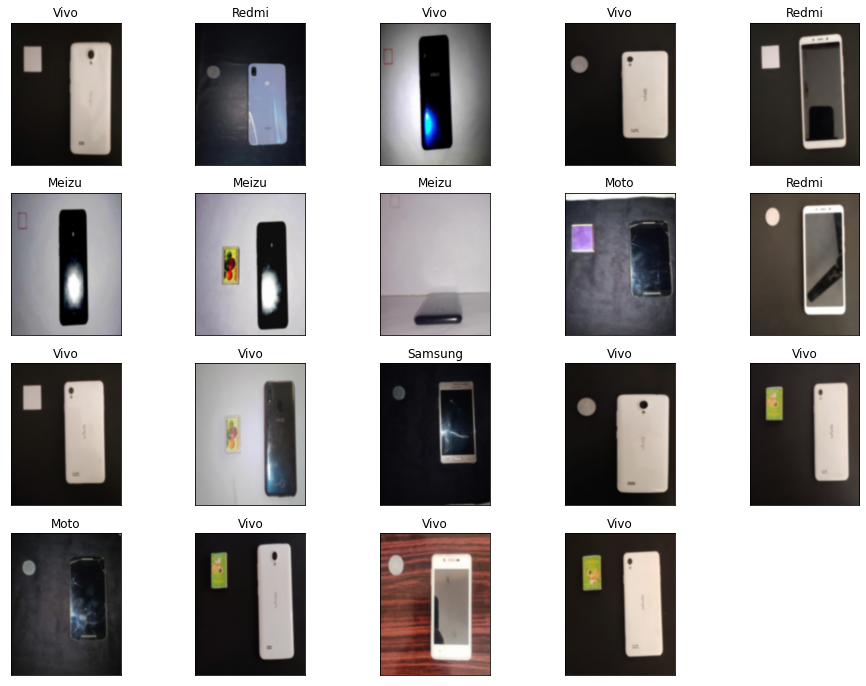

In [26]:
temp.show(19,ncol=5,randomize=True)

### Reducing Noise and Detecting Edges Using the processImages Action.
#### Input: imgsOut_1  Output: imgsOut_2

In [27]:
s.image.processImages(
    casout={'name':'imgsOut_2'},
    imagefunctions=[
        {'options':{
            'functiontype':'BILATERAL_FILTER',
            'diameter':13,
            'sigmacolor':30,
            'sigmaspace':30
        }},
        {'options':{
            'functiontype':'CONVERT_COLOR',
            'type':'COLOR2GRAY'
        }},
        {'options':{
            'functiontype':'LAPLACIAN',
            'kernelsize':1,
            'delta':0,
            'scale':1,
        }}
    ],
    table={'name':'imgsOut_1'}
)

NOTE: Table IMGSOUT_1 contains compressed images.
NOTE: 19 out of 19 images were processed successfully and saved as compressed images to the Cloud Analytic Services table imgsOut_2.


+ Elapsed: 0.329s, user: 4.93s, mem: 67.9mb

In [28]:
temp=ImageTable.from_table(s.CASTable('imgsOut_2'), image_col='_image_', label_col='_label_', path_col=None, columns=None, casout=None)

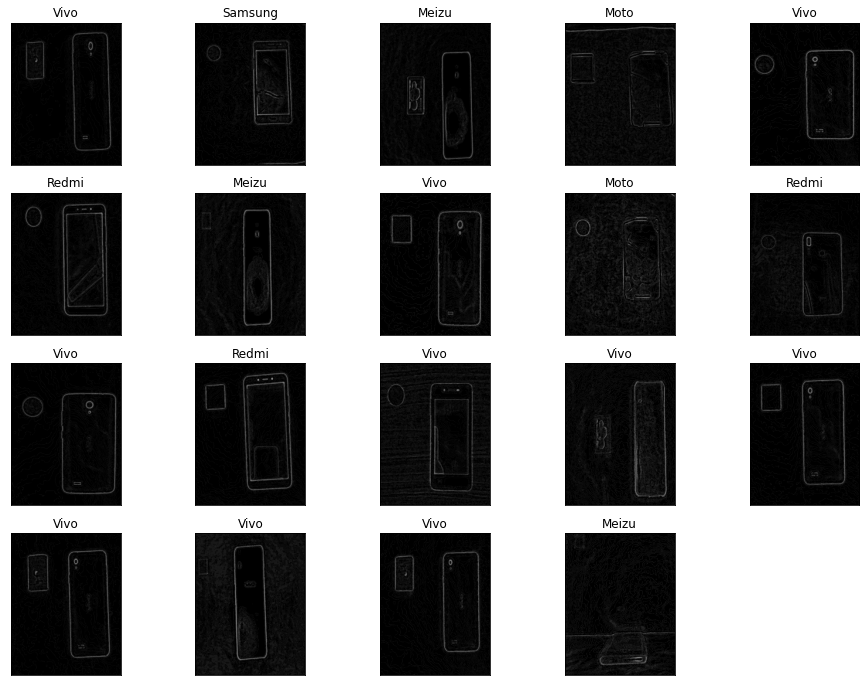

In [29]:
temp.show(19,ncol=5,randomize=True)

In [ ]:
#edged = cv2.Canny(temp, 50, 100,100)
#edged = cv2.dilate(edged, None, iterations=1)
#edged = cv2.erode(edged, None, iterations=1) 

### Detecting Edges with Canny Using the processImages Action
#### Input: imgsOut_2   Output:imgsOut_3

In [30]:
s.image.processImages(
    casout={'name':'imgsOut_3'},
    imagefunctions=[
        {'options':{
            'functiontype':'CANNY_EDGE',
            'lowthreshold':40,
            'highthreshold':80,
            'kernelsize':3
        }}
    ],
    table={'name':'imgsOut_1'}
)

NOTE: Table IMGSOUT_1 contains compressed images.
NOTE: 19 out of 19 images were processed successfully and saved as compressed images to the Cloud Analytic Services table imgsOut_3.


+ Elapsed: 0.0398s, user: 0.41s, sys: 0.0354s, mem: 67.9mb

In [31]:
temp=ImageTable.from_table(s.CASTable('imgsOut_3'), image_col='_image_', label_col='_label_', path_col=None, columns=None, casout=None)

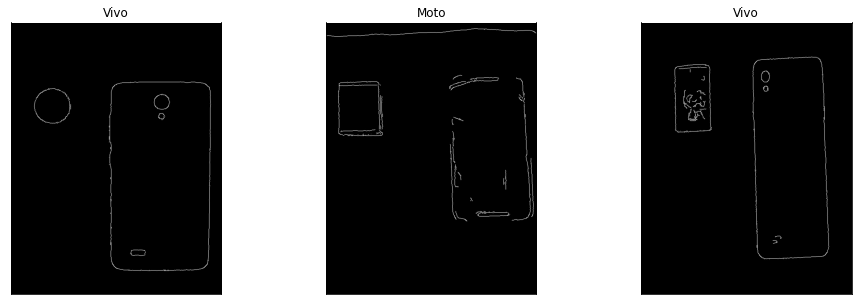

In [32]:
temp.show(3,ncol=3,randomize=True)

In [ ]:
#s.endsession()